## Intervening on subcomponents

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "11/15/2023"

### Overview

This tutorial shows how you can intervene at specific position within representations of a specific head. This is sort of nested interventions where you choose a head to intervene first, and then you choose a specific location, or multiple locations. 

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [2]:
import pandas as pd
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

### Factual Recall

In [3]:
config, tokenizer, gpt = create_gpt2()

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [tokenizer(base, return_tensors="pt"), tokenizer(source, return_tensors="pt")]
print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = gpt(**inputs[1])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The capital of Spain is
_Madrid              0.10501234978437424
_the                 0.0949699655175209
_Barcelona           0.0702790841460228
_a                   0.04010068252682686
_now                 0.02824278175830841
_in                  0.02759990654885769
_Spain               0.022991720587015152
_Catalonia           0.018823225051164627
_also                0.018689140677452087
_not                 0.01735665090382099

The capital of Italy is
_Rome                0.15734916925430298
_the                 0.07316355407238007
_Milan               0.046878915280103683
_a                   0.03449810668826103
_now                 0.03200329467654228
_in                  0.02306535840034485
_also                0.02274816483259201
_home                0.01920313946902752
_not                 0.01640527881681919
_Italy               0.01577090471982956


### Patch Patching on Position-aligned Tokens with in Specific Head
We path patch on two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

Different from the basic tutorial, this tutorial intervenes on specific locations within specific heads. For instance, we want to intervene on the last token in head 4 but not other heads.

**To do this, we need to tweak a little when we setup the intervention config.**

In [4]:
def position_in_head_config(model_type, intervention_type, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,  # layer
                intervention_type,  # intervention type
                "h.pos",  # intervention unit is now [pos] within [h]
                1,  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]

In [5]:
target_head = 0

# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")

data = []
for layer_i in range(gpt.config.n_layer):
    config = position_in_head_config(
        type(gpt), "head_attention_value_output", layer_i
    )
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            sources,
            {
                "sources->base": (
                    [[[[target_head]], [[pos_i]]]],  # intervene w/ target_head's pos_i
                    [[[[target_head]], [[pos_i]]]],  # intervene on target_head's pos_i
                )
            },
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"ov{layer_i}",
                    "pos": pos_i,
                    "type": "head_attention_value_output",
                }
            )

    config = position_in_head_config(
        type(gpt), "head_value_output", layer_i
    )
    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            sources,
            {
                "sources->base": (
                    [[[[target_head]], [[pos_i]]]],  # intervene w/ target_head's pos_i
                    [[[[target_head]], [[pos_i]]]],  # intervene on target_head's pos_i
                )
            },
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"v{layer_i}",
                    "pos": pos_i,
                    "type": "head_value_output",
                }
            )
df = pd.DataFrame(data)

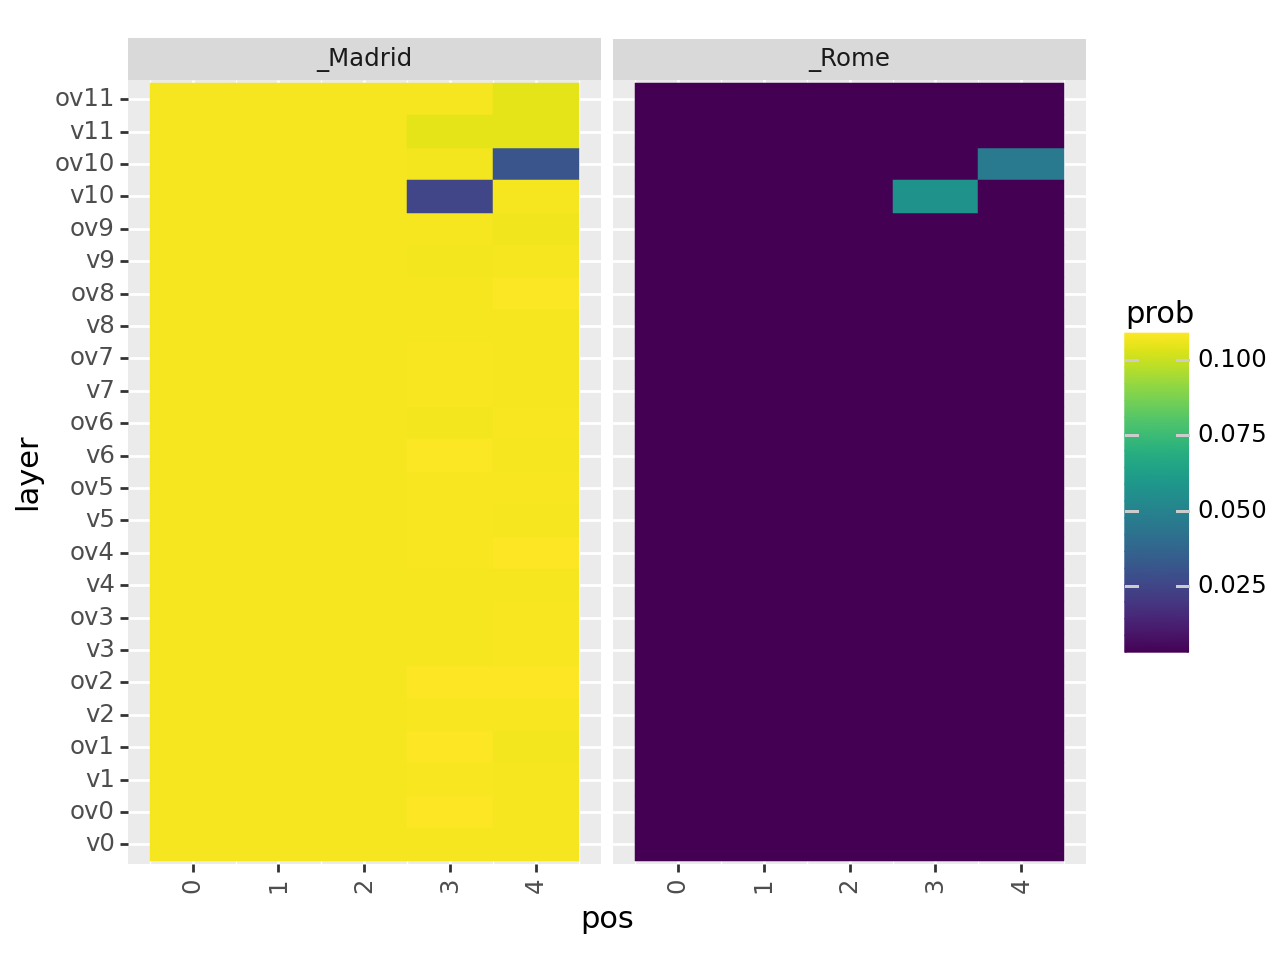

In [7]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for l in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f"ov{l}")
    nodes.append(f"v{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
print(g)

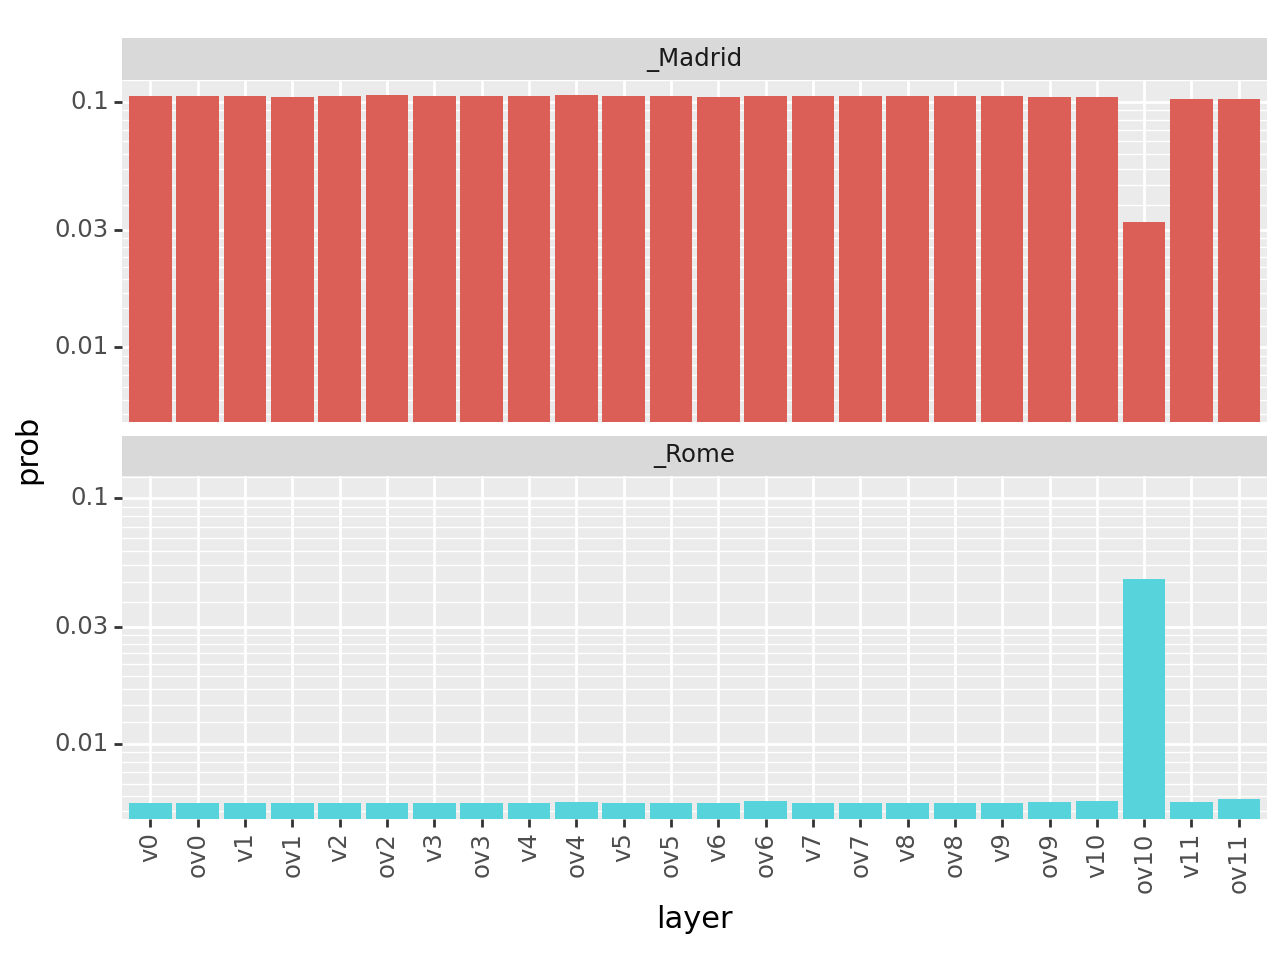

In [14]:
filtered = df
filtered = filtered[filtered["pos"] == 4]
g = (
    ggplot(filtered)
    + geom_bar(aes(x="layer", y="prob", fill="token"), stat="identity")
    + theme(axis_text_x=element_text(rotation=90), legend_position="none")
    + scale_y_log10()
    + facet_wrap("~token", ncol=1)
)
print(g)